In [3]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [4]:
# Starbucks stock data form 2013-2018
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [5]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [6]:
# Clean data - no nulls
df.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [7]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [8]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [9]:
series = df['close'].values.reshape(-1, 1)

In [11]:
df['PrevClose'] = df['close'].shift(1)

In [12]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [13]:
# Return column 
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [31]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


In [15]:
# Normalize/Scale the Returns
series = df['Return'].values[1:].reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [21]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [29]:
input_data.shape

(1259, 5)

In [30]:
T = 10 # number of steps to look for prediction of next day, experiment for optimal
D = input_data.shape[1] # no. of columns in input data
N = len(input_data) - T

In [32]:
# Normalize the inputs
ntrain = len(input_data) * 2//3
scaler = StandardScaler()
scaler.fit(input_data[:ntrain + T])
input_data = scaler.transform(input_data)

In [41]:
# Train sets 
x_train = np.zeros((ntrain, T, D))
y_train = np.zeros(ntrain)

for t in range(ntrain):
    x_train[t, :, :] = input_data[t:t+T]
    y_train[t] = (targets[t+T] > 0)

In [42]:
# Test Sets
x_test = np.zeros((N-ntrain, T, D))
y_test = np.zeros(N - ntrain)

for u in range(N - ntrain):
    t = u + ntrain
    x_test[u, :, :] = input_data[t:t+T]
    y_test[u] = (targets[t+T] > 0)

In [45]:
i = Input(shape=(T, D))
X = LSTM(50)(i)
X = Dense(1, activation='sigmoid')(X)
model = Model(i, X)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'],)

In [46]:
r = model.fit(x_train, y_train, batch_size=32, epochs=300, validation_data=(x_test, y_test),)

Epoch 1/300
27/27 [==============================] - 3s 23ms/step - loss: 0.6978 - accuracy: 0.4911 - val_loss: 0.6997 - val_accuracy: 0.4829
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5125 - val_loss: 0.6942 - val_accuracy: 0.4805
Epoch 3/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5292 - val_loss: 0.6961 - val_accuracy: 0.4756
Epoch 4/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5185 - val_loss: 0.6943 - val_accuracy: 0.4829
Epoch 5/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5316 - val_loss: 0.6926 - val_accuracy: 0.5073
Epoch 6/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.5244 - val_loss: 0.6946 - val_accuracy: 0.4951
Epoch 7/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.5340 - val_loss: 0.6913 - val_accuracy: 0.5293
Epoch 8/300


Epoch 59/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6672 - accuracy: 0.5757 - val_loss: 0.7037 - val_accuracy: 0.4878
Epoch 60/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6659 - accuracy: 0.5781 - val_loss: 0.7022 - val_accuracy: 0.5122
Epoch 61/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6662 - accuracy: 0.5757 - val_loss: 0.7034 - val_accuracy: 0.4976
Epoch 62/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6648 - accuracy: 0.5864 - val_loss: 0.7147 - val_accuracy: 0.5098
Epoch 63/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6643 - accuracy: 0.5900 - val_loss: 0.6998 - val_accuracy: 0.5024
Epoch 64/300
27/27 [==============================] - 0s 5ms/step - loss: 0.6644 - accuracy: 0.5805 - val_loss: 0.7144 - val_accuracy: 0.4902
Epoch 65/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6628 - accuracy: 0.5840 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 

27/27 [==============================] - 0s 6ms/step - loss: 0.5982 - accuracy: 0.6579 - val_loss: 0.7584 - val_accuracy: 0.4537
Epoch 117/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5998 - accuracy: 0.6615 - val_loss: 0.7504 - val_accuracy: 0.4585
Epoch 118/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5979 - accuracy: 0.6782 - val_loss: 0.7591 - val_accuracy: 0.4415
Epoch 119/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5926 - accuracy: 0.6794 - val_loss: 0.7620 - val_accuracy: 0.4439
Epoch 120/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5909 - accuracy: 0.6794 - val_loss: 0.7637 - val_accuracy: 0.4488
Epoch 121/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5905 - accuracy: 0.6663 - val_loss: 0.7641 - val_accuracy: 0.4561
Epoch 122/300
27/27 [==============================] - 0s 6ms/step - loss: 0.5887 - accuracy: 0.6651 - val_loss: 0.7618 - val_accuracy: 0.4488
Epoch 123/300

27/27 [==============================] - 0s 6ms/step - loss: 0.4415 - accuracy: 0.7843 - val_loss: 0.9024 - val_accuracy: 0.4317
Epoch 174/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4374 - accuracy: 0.7902 - val_loss: 0.8820 - val_accuracy: 0.4537
Epoch 175/300
27/27 [==============================] - 0s 5ms/step - loss: 0.4423 - accuracy: 0.7795 - val_loss: 0.8841 - val_accuracy: 0.4659
Epoch 176/300
27/27 [==============================] - 0s 5ms/step - loss: 0.4333 - accuracy: 0.7998 - val_loss: 0.9071 - val_accuracy: 0.4341
Epoch 177/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4404 - accuracy: 0.7747 - val_loss: 0.8819 - val_accuracy: 0.4415
Epoch 178/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4336 - accuracy: 0.7902 - val_loss: 0.9177 - val_accuracy: 0.4268
Epoch 179/300
27/27 [==============================] - 0s 6ms/step - loss: 0.4330 - accuracy: 0.7878 - val_loss: 0.9038 - val_accuracy: 0.4683
Epoch 180/300

27/27 [==============================] - 0s 6ms/step - loss: 0.2730 - accuracy: 0.8844 - val_loss: 1.0929 - val_accuracy: 0.4780
Epoch 231/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2878 - accuracy: 0.8796 - val_loss: 1.1247 - val_accuracy: 0.4463
Epoch 232/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2706 - accuracy: 0.8975 - val_loss: 1.1126 - val_accuracy: 0.4707
Epoch 233/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2541 - accuracy: 0.8963 - val_loss: 1.1333 - val_accuracy: 0.4634
Epoch 234/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2585 - accuracy: 0.8927 - val_loss: 1.0985 - val_accuracy: 0.4756
Epoch 235/300
27/27 [==============================] - 0s 5ms/step - loss: 0.2562 - accuracy: 0.8963 - val_loss: 1.1723 - val_accuracy: 0.4561
Epoch 236/300
27/27 [==============================] - 0s 6ms/step - loss: 0.2514 - accuracy: 0.8903 - val_loss: 1.1060 - val_accuracy: 0.4951
Epoch 237/300

27/27 [==============================] - 0s 6ms/step - loss: 0.1334 - accuracy: 0.9547 - val_loss: 1.4231 - val_accuracy: 0.4707
Epoch 288/300
27/27 [==============================] - 0s 7ms/step - loss: 0.1322 - accuracy: 0.9571 - val_loss: 1.4264 - val_accuracy: 0.4805
Epoch 289/300
27/27 [==============================] - 0s 7ms/step - loss: 0.1418 - accuracy: 0.9476 - val_loss: 1.4736 - val_accuracy: 0.4537
Epoch 290/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1427 - accuracy: 0.9476 - val_loss: 1.4824 - val_accuracy: 0.4780
Epoch 291/300
27/27 [==============================] - 0s 7ms/step - loss: 0.1350 - accuracy: 0.9571 - val_loss: 1.4332 - val_accuracy: 0.4902
Epoch 292/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.9535 - val_loss: 1.5245 - val_accuracy: 0.4610
Epoch 293/300
27/27 [==============================] - 0s 6ms/step - loss: 0.1326 - accuracy: 0.9571 - val_loss: 1.4797 - val_accuracy: 0.4707
Epoch 294/300

### The graph represents overfitting on the train model

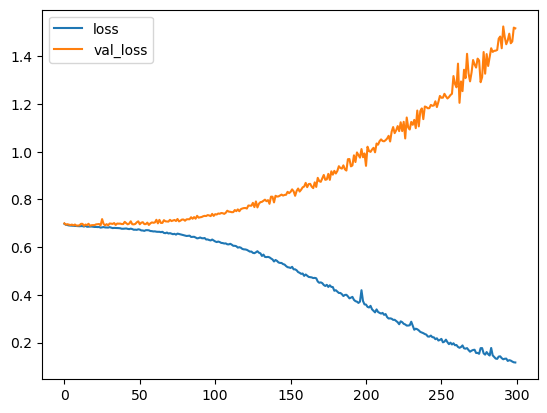

In [48]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();
plt.show();

### Accuracy around 40%

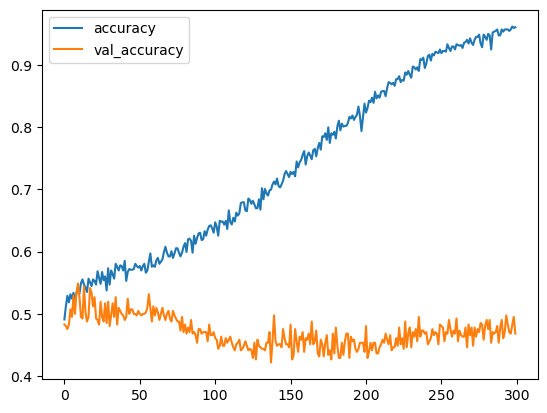

In [50]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend();
plt.show();

### The model is incomplete, add Technical Indicators and other models